###  Title: Implementing Autoencoders in Keras: Tutorial
#### Author: Aditya Sharma
###### url: https://www.datacamp.com/tutorial/autoencoder-keras-tutorial

In [1]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1




In [2]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop

#from keras.optimizers import RMSprop -> this doesnt work
# it shoueld be --> from tensorflow.keras.optimizers import RMSprop


Here, you define a function that opens the gzip file, reads the file using bytestream.read(). You pass the image dimension and the total number of images to this function. Then, using np.frombuffer(), you convert the string stored in variable buf into a NumPy array of type float32.

Next, you reshape the array into a three-dimensional array or tensor where the first dimension is number of images, and the second and third dimension being the dimension of the image. Finally, you return the NumPy array data.

In [3]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data


You will now call the function extract_data() by passing the training and testing files along with their corresponding number of images:

In [4]:
train_data = extract_data('./sourcedata/notMNIST-to-MNIST-master/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('./sourcedata/notMNIST-to-MNIST-master/t10k-images-idx3-ubyte.gz', 10000)

Similarly, you define a extract labels function that opens the gzip file, reads the file using bytestream.read(), to which you pass the label dimension (1) and the total number of images. Then, using np.frombuffer(), you convert the string stored in variable buf into a NumPy array of type int64.

This time, you do not need to reshape the array since the variable labels will return a column vector of dimension 60,000 x 1. Finally, you return the NumPy array labels.

In [5]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels


You will now call the function extract label by passing the training and testing label files along with their corresponding number of images:

In [6]:
train_labels = extract_labels('./sourcedata/notMNIST-to-MNIST-master/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('./sourcedata/notMNIST-to-MNIST-master/t10k-labels-idx1-ubyte.gz',10000)


Once you have the training and testing data loaded, you are all set to analyze the data in order to get some intuition about the dataset that you are going to work with for today's tutorial!

Let's now analyze how images in the dataset look like and also see the dimension of the images with the help of the NumPy array attribute .shape:

In [7]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))
print(f"Training set images shape is\n{train_data.shape[0]} training samples\n{train_data.shape[1]}x{train_data.shape[2]} dimensional matrix")

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))


Training set (images) shape: (60000, 28, 28)
Training set images shape is
60000 training samples
28x28 dimensional matrix
Test set (images) shape: (10000, 28, 28)


From the above output, you can see that the training data has a shape of 60000 x 28 x 28 since there are 60,000 training samples each of 28 x 28 dimensional matrix. Similarly, the test data has a shape of 10000 x 28 x 28 since there are 10,000 testing samples.

Note that in this task, you will not be using the training and testing labels. The task at hand will only be dealing with the training and testing images. However, for exploration purposes, which might give you a better intuition about the data, you'll make use the labels.

Let's create a dictionary that will have class names with their corresponding categorical class labels:

In [8]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}


Now, let's take a look at couple of the images in your dataset:

Text(0.5, 1.0, '(Label: D)')

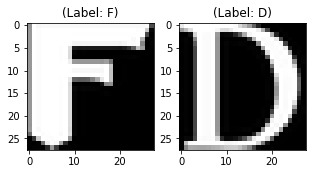

In [9]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

Data Preprocessing
The images of the dataset are indeed grayscale images with pixel values ranging from 0 to 255 with a dimension of 28 x 28 so before you feed the data into the model it is very important to preprocess it. You'll first convert each 28 x 28 image of train and test set into a matrix of size 28 x 28 x 1, which you can feed into the network:

In [10]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Next, you want to make sure to check the data type of the training and testing NumPy arrays, it should be in float32 format, if not you will need to convert it into this format, but since you already have converted it while reading the data you no longer need to do this again. You also have to rescale the pixel values in range 0 - 1 inclusive. So let's do that!

Don't forget to verify the training and testing data types:



In [11]:
train_data.dtype, test_data.dtype


(dtype('float32'), dtype('float32'))

Next, rescale the training and testing data with the maximum pixel value of the training and testing data:

In [12]:
np.max(train_data), np.max(test_data)
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)


Let's verify the maximum value of training and testing data which should be 1.0 after rescaling it!

In [13]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

After all of this, it's important to partition the data. In order for your model to generalize well, you split the training data into two parts: a training and a validation set. You will train your model on 80% of the data and validate it on 20% of the remaining training data.

This will also help you in reducing the chances of overfitting, as you will be validating your model on data it would not have seen in training phase.

You can use the train_test_split module of scikit-learn to divide the data properly:

In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)


Note that for this task, you don't need training and testing labels. That's why you will pass the training images twice. Your training images will both act as the input as well as the ground truth similar to the labels you have in classification task.

Now you are all set to define the network and feed the data into the network. So without any further ado, let's jump to the next step!

### The Convolutional Autoencoder
The images are of size 28 x 28 x 1 or a 784-dimensional vector. You convert the image matrix to an array, rescale it between 0 and 1, reshape it so that it's of size 28 x 28 x 1, and feed this as an input to the network.

Also, you will use a batch size of 128 using a higher batch size of 256 or 512 is also preferable it all depends on the system you train your model. It contributes heavily in determining the learning parameters and affects the prediction accuracy. You will train your network for 50 epochs.

In [15]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))


As discussed before, the autoencoder is divided into two parts: there's an encoder and a decoder.

Encoder

The first layer will have 32 filters of size 3 x 3, followed by a downsampling (max-pooling) layer,
The second layer will have 64 filters of size 3 x 3, followed by another downsampling layer,
The final layer of encoder will have 128 filters of size 3 x 3.


Decoder

The first layer will have 128 filters of size 3 x 3 followed by a upsampling layer,/li>
The second layer will have 64 filters of size 3 x 3 followed by another upsampling layer,
The final layer of encoder will have 1 filter of size 3 x 3.
The max-pooling layer will downsample the input by two times each time you use it, while the upsampling layer will upsample the input by two times each time it is used.

##### Note: The number of filters, the filter size, the number of layers, number of epochs you train your model, are all hyperparameters and should be decided based on your own intuition, you are free to try new experiments by tweaking with these hyperparameters and measure the performance of your model. And that is how you will slowly learn the art of deep learning!

In [16]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded


After the model is created, you have to compile it using the optimizer to be RMSProp.

Tip: watch this tutorial:https://www.coursera.org/learn/deep-neural-network/lecture/BhJlm/rmsprop by Andrew Ng on RMSProp if you want to get to know more about RMSProp.

Note that you also have to specify the loss type via the argument loss. In this case, that's the mean squared error, since the loss after every batch will be computed between the batch of predicted output and the ground truth using mean squared error pixel by pixel:

In [17]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

2022-11-22 11:08:45.192672: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Output from previous 
2022-11-21 19:15:46.230641: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

Let's visualize the layers that you created in the above step by using the summary function, this will show number of parameters (weights and biases) in each layer and also the total parameters in your model.

In [21]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856 

In [19]:
#autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))
